In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from cool_image_functions import *
%matplotlib inline

In [2]:
caliberate_camera()

(array([[  1.15777818e+03,   0.00000000e+00,   6.67113857e+02],
        [  0.00000000e+00,   1.15282217e+03,   3.86124583e+02],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]]),
 array([[-0.24688507, -0.02373156, -0.00109831,  0.00035107, -0.00259866]]))

In [3]:
#load the caliberation result and use for undistorting any imag
dist_pickle = pickle.load( open( "camera_cal/mtx_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

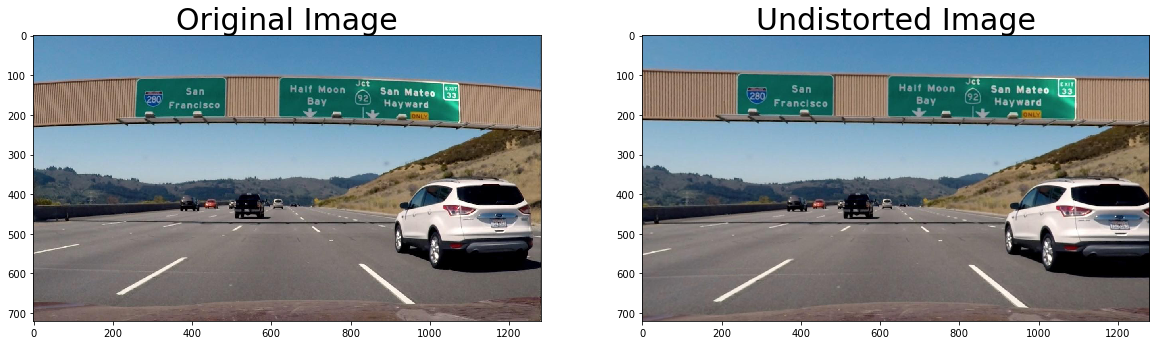

In [4]:
img = cv2.imread('test_images/undistortion_test.png')
#img = cv2.imread('camera_cal/calibration3.jpg')
image_shape = img.shape
undistorted_img = cal_undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img[...,::-1])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_img[...,::-1])
ax2.set_title('Undistorted Image', fontsize=30)

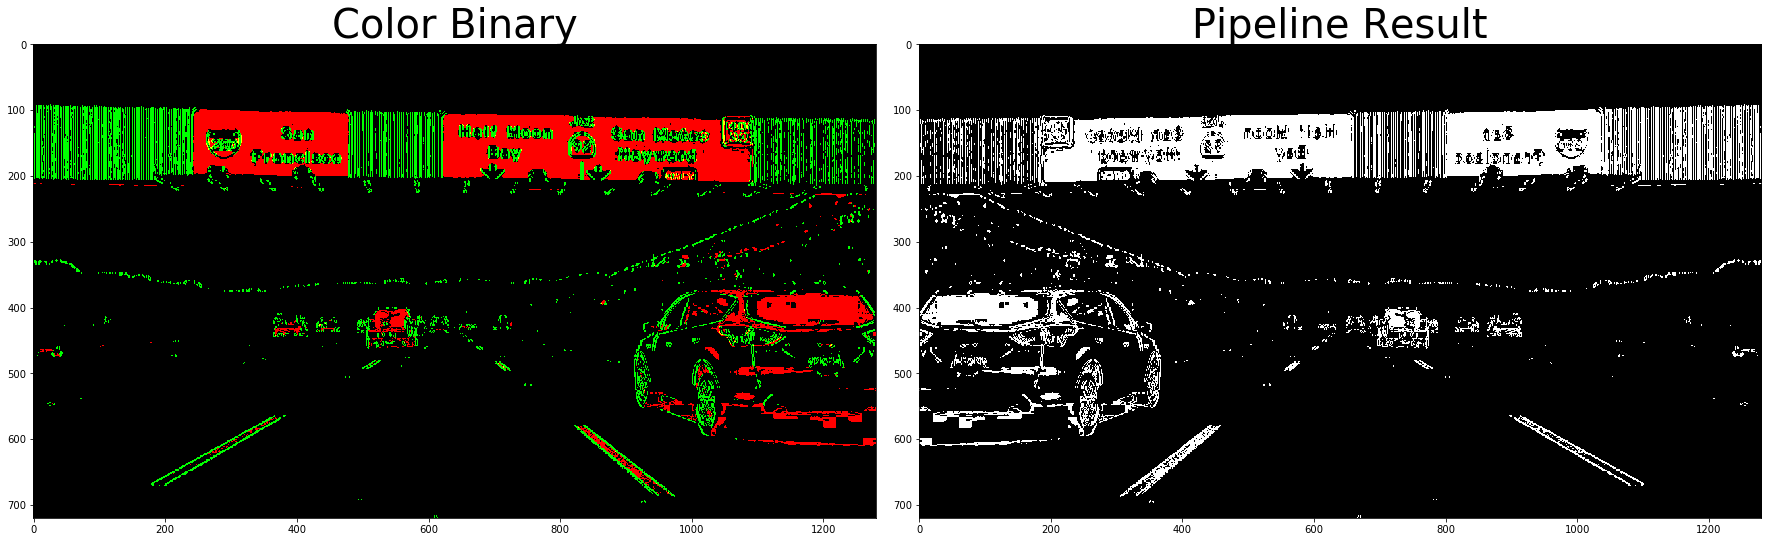

In [5]:
#image = mpimg.imread('test_images/test6.jpg')  
#color_binary to check the individual contributions of x_gradient and color channel (170, 255), (20, 100)
processed_image, color_binary = apply_color_and_gradient_threshold(undistorted_img, (170, 255), (30, 100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(color_binary[...,::-1])
ax1.set_title('Color Binary', fontsize=40)

ax2.imshow(processed_image[...,::-1], cmap="gray")
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


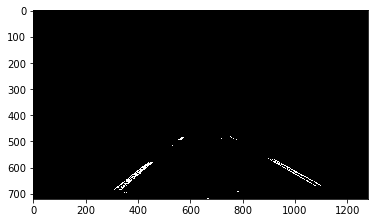

In [6]:
points = np.array([[(0,image_shape[0]),(550, 470), (700, 470), (image_shape[1],image_shape[0])]], dtype=np.int32)
masked_image = mask_this_image(processed_image, points)
plt.imshow(masked_image[...,::-1], cmap="gray")


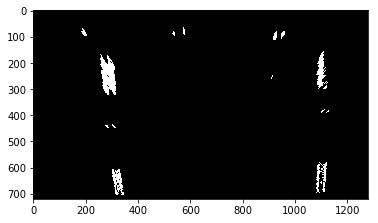

In [7]:
src = np.float32(
    [[120, 720],
     [550, 470],
     [700, 470],
     [1160, 720]])

dst = np.float32(
    [[200,720],
     [200,0],
     [1080,0],
     [1080,720]])

warped_image, Minv = transform_perspective(src, dst, masked_image, image_shape)
plt.imshow(warped_image[...,::-1], cmap="gray")

In [8]:
leftx, lefty, rightx, righty, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds   = extract_pixel_positions(warped_image)

left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


(720, 0)

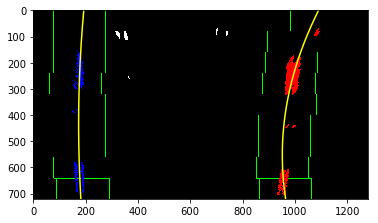

In [9]:
ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

blank_canvas = np.zeros((720, 1280))
colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

plt.imshow(out_img[...,::-1], cmap='gray')
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [10]:
# Determine curvature of the lane
y_eval = 500

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

curvature = (left_curverad + right_curverad) / 2
centre = center(719, left_fit, right_fit)
print (curvature, centre)

1572.47975057 m 362.820907237 m
967.650328904 -345.959680684


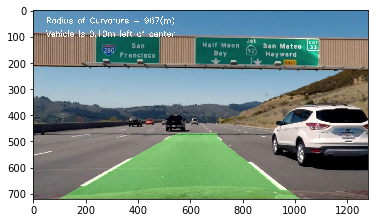

In [11]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped_image).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image_shape[1], image_shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)

write_data_on_image(result, curvature=curvature, vehicle_position=centre)


plt.imshow(result[...,::-1])